# Sparse Optical Flow

This notebook is an implementation of Optical Flow algorithmps, following learnOpenCV article called **Optical Flow in OpenCV**

### Lucas-Kanade algorithm

In [22]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display, clear_output
import ipywidgets as widgets
from pathlib import Path

In [23]:
def lucas_kanade_method(video_path, display_inline=True, save_output=False, output_path='output.mp4'):
    """
    Lucas-Kanade with debugging and error handling
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"ERROR: Cannot open video file: {video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video info: {width}x{height}, {fps} fps, {total_frames} frames")
    
    # Setup video writer
    if save_output:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Parameters for ShiTomasi corner detection
    feature_params = dict(
        maxCorners=100,
        qualityLevel=0.3,
        minDistance=7,
        blockSize=7
    )
    
    # Parameters for Lucas Kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    
    # Create random colors
    color = np.random.randint(0, 255, (100, 3))
    
    # Read first frame
    ret, old_frame = cap.read()
    if not ret:
        print("ERROR: Could not read first frame")
        return
    
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    
    # Check if features were detected
    if p0 is None or len(p0) == 0:
        print("ERROR: No features detected in first frame!")
        print("Suggestions:")
        print("  - Try a video with more texture/corners")
        print("  - Lower qualityLevel (e.g., 0.1)")
        print("  - Check if video is too dark or blurry")
        return
    
    print(f"✓ Detected {len(p0)} features in first frame")
    
    # Create mask for drawing
    mask = np.zeros_like(old_frame)
    
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, frame_gray, p0, None, **lk_params
        )
        
        # Check if tracking succeeded
        if p1 is None or st is None:
            print(f"Frame {frame_count}: Tracking failed, re-detecting features")
            p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
            if p0 is None:
                print("Cannot re-detect features")
                break
            mask = np.zeros_like(frame)
            old_gray = frame_gray.copy()
            frame_count += 1
            continue
        
        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        
        if len(good_new) == 0:
            print(f"Frame {frame_count}: All points lost, re-detecting")
            p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
            if p0 is None:
                print("Cannot re-detect features")
                break
            mask = np.zeros_like(frame)
            old_gray = frame_gray.copy()
            frame_count += 1
            continue
        
        # Draw the tracks - FIXED INTEGER CONVERSION
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            # CRITICAL FIX: Convert to integers properly
            a, b = int(new[0]), int(new[1])
            c, d = int(old[0]), int(old[1])
            
            # Ensure coordinates are within frame bounds
            if 0 <= a < width and 0 <= b < height and 0 <= c < width and 0 <= d < height:
                mask = cv2.line(mask, (a, b), (c, d), color[i % len(color)].tolist(), 2)
                frame = cv2.circle(frame, (a, b), 5, color[i % len(color)].tolist(), -1)
        
        # Combine frame and mask
        img = cv2.add(frame, mask)
        
        # Save output
        if save_output:
            out.write(img)
        
        # Display inline (every 5 frames)
        if display_inline and frame_count % 5 == 0:
            clear_output(wait=True)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(12, 8))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f'Frame {frame_count} - Tracking {len(good_new)} points')
            plt.show()
        
        # Print progress
        if frame_count % 30 == 0:
            print(f"Frame {frame_count}/{total_frames}: Tracking {len(good_new)} points")
        
        # Update previous frame and points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
        
        frame_count += 1
    
    # Cleanup
    cap.release()
    if save_output:
        out.release()
        print(f"✓ Output saved to {output_path}")
    
    print(f"✓ Processed {frame_count} frames")

### Motion Visualization Algorithm

The algorithm visualizes motion in a video by:

1. **Detecting interesting points** (corners/features) in the first frame using the **Shi-Tomasi corner detection** method.  
2. **Tracking these points** across subsequent frames to see where they move.  
3. **Drawing colored trails** showing the path each point has traveled.  
4. **Displaying circles** at the current position of each tracked point.  

#### For each subsequent frame:

- **Optical Flow Calculation:**  
  Uses `cv2.calcOpticalFlowPyrLK()` (Lucas-Kanade pyramid method) to find where each tracked point moved to in the new frame.  

- **Point Filtering:**  
  Keeps only *good* points that were successfully tracked (`st == 1`).  

- **Visualization:**  
  - Draws lines from the old position to the new position (creating motion trails).  
  - Draws circles at the current position of each point.  

- **Updates:**  
  Sets the current frame as the *old frame* for the next iteration.


Quality 0.3: 9 features
Quality 0.1: 35 features
Quality 0.01: 100 features


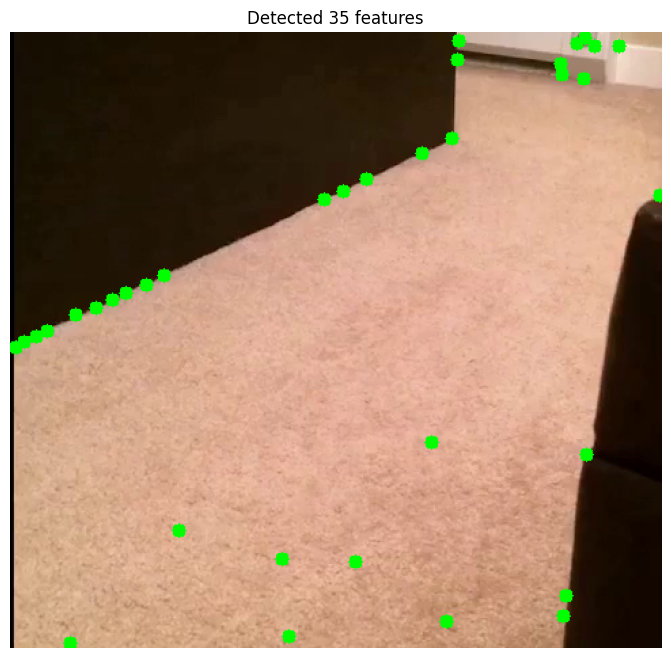

In [24]:
def test_feature_detection(video_path):
    """Test if features can be detected in your video"""
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    
    if not ret:
        print("Cannot read video!")
        return
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Try different quality levels
    for quality in [0.3, 0.1, 0.01]:
        features = cv2.goodFeaturesToTrack(
            gray, 
            maxCorners=100, 
            qualityLevel=quality, 
            minDistance=7
        )
        print(f"Quality {quality}: {len(features) if features is not None else 0} features")
    
    # Visualize detected corners
    features = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.1, minDistance=7)
    
    if features is not None:
        frame_copy = frame.copy()
        for corner in features:
            x, y = int(corner[0][0]), int(corner[0][1])
            cv2.circle(frame_copy, (x, y), 5, (0, 255, 0), -1)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
        plt.title(f'Detected {len(features)} features')
        plt.axis('off')
        plt.show()
    else:
        print("NO FEATURES DETECTED - try a different video!")
    
    cap.release()

# Test your video
test_feature_detection('my_video.mp4')


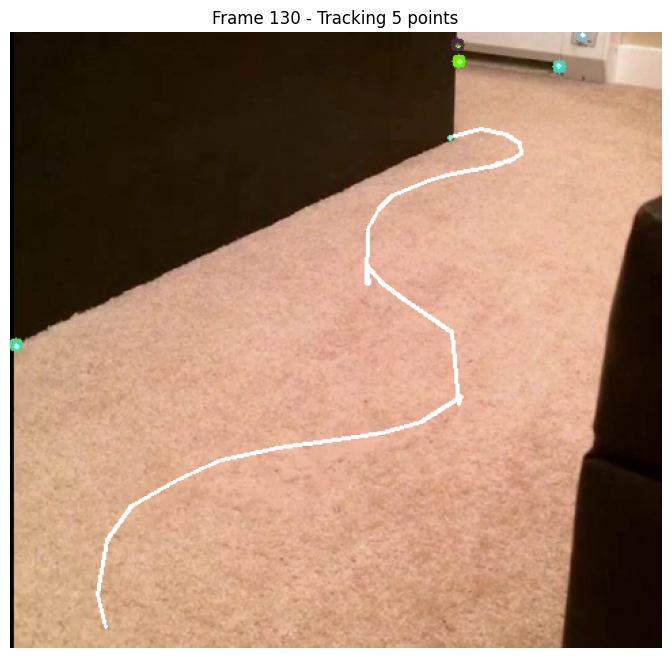

✓ Processed 135 frames


In [27]:
lucas_kanade_method('my_video.mp4', display_inline=True, save_output=False)

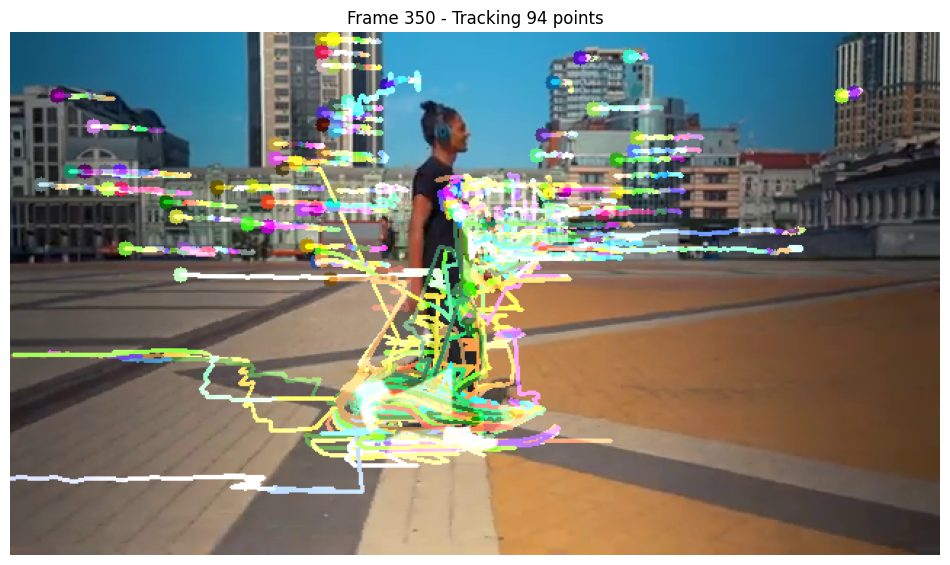

✓ Processed 355 frames


In [28]:
lucas_kanade_method('my_video2.mp4', display_inline=True, save_output=False)


### Dense Optical Flow 

In [ ]:
def show_optical_flow_color_legend():
    """
    Display color legend for optical flow visualization
    """
    # Create a color wheel showing direction and magnitude
    size = 300
    center = size // 2
    
    # Create grid
    y, x = np.mgrid[0:size, 0:size].astype(np.float32)
    
    # Calculate angle and magnitude from center
    dx = x - center
    dy = y - center
    
    angle = np.arctan2(dy, dx)
    magnitude = np.sqrt(dx**2 + dy**2)
    
    # Normalize
    magnitude = np.clip(magnitude / (size/2), 0, 1) * 255
    
    # Create HSV
    hsv = np.zeros((size, size, 3), dtype=np.uint8)
    hsv[..., 0] = (angle * 180 / np.pi / 2).astype(np.uint8)
    hsv[..., 1] = 255
    hsv[..., 2] = magnitude.astype(np.uint8)
    
    # Convert to BGR
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb)
    plt.title('Optical Flow Color Legend\\n(Hue=Direction, Brightness=Magnitude)', fontsize=14)
    
    # Add direction labels
    plt.text(center + center*0.8, center, 'Right →', ha='center', fontsize=12, color='white', weight='bold')
    plt.text(center - center*0.8, center, '← Left', ha='center', fontsize=12, color='white', weight='bold')
    plt.text(center, center - center*0.8, '↑ Up', ha='center', fontsize=12, color='white', weight='bold')
    plt.text(center, center + center*0.8, '↓ Down', ha='center', fontsize=12, color='white', weight='bold')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the legend
show_optical_flow_color_legend()


In [ ]:
def dense_optical_flow(method, video_path, params=[], to_gray=False, 
                       save_output=False, output_path='dense_flow_output.mp4',
                       display_inline=True, display_every=1):
    """
    Generic dense optical flow calculator for Jupyter notebooks
    
    Args:
        method: OpenCV optical flow function (e.g., cv2.calcOpticalFlowFarneback)
        video_path: Path to input video
        params: List of parameters for the specific method
        to_gray: Whether to convert frames to grayscale
        save_output: Save output video
        output_path: Path for output video
        display_inline: Display frames in notebook
        display_every: Display every Nth frame
    """
    # Read video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"ERROR: Cannot open video: {video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video Properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Setup video writer
    if save_output:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Read first frame
    ret, old_frame = cap.read()
    if not ret:
        print("ERROR: Cannot read first frame")
        return
    
    # Create HSV image for visualization
    hsv = np.zeros_like(old_frame)
    hsv[..., 1] = 255  # Set saturation to maximum
    
    # Preprocessing if needed
    if to_gray:
        old_frame = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    
    frame_count = 0
    
    while True:
        # Read new frame
        ret, new_frame = cap.read()
        if not ret:
            break
        
        frame_copy = new_frame.copy()
        
        # Preprocessing
        if to_gray:
            new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow
        flow = method(old_frame, new_frame, None, *params)
        
        # Convert flow to polar coordinates
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        # Encode into HSV
        hsv[..., 0] = angle * 180 / np.pi / 2  # Hue = direction
        hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)  # Value = magnitude
        
        # Convert HSV to BGR for visualization
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        
        # Save frame
        if save_output:
            out.write(bgr)
        
        # Display inline
        if display_inline and frame_count % display_every == 0:
            clear_output(wait=True)
            
            # Create side-by-side comparison
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Original frame
            axes[0].imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
            # axes.set_title(f'Original Frame {frame_count}')
            # axes.axis('off')
            
            # Optical flow
            axes[1].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
            # axes.set_title(f'Dense Optical Flow (Frame {frame_count})')
            # axes.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            
        
        # Progress update
        if frame_count % 30 == 0:
            print(f"Processing: Frame {frame_count}/{total_frames}")
        
        # Update previous frame
        old_frame = new_frame.copy()
        frame_count += 1
    
    # Cleanup
    cap.release()
    if save_output:
        out.release()
        print(f"✓ Output saved to: {output_path}")
    
    print(f"✓ Processed {frame_count} frames")
    return frame_count


### Algorithm 1: Farneback Dense Optical Flow

In [ ]:
def farneback_optical_flow(video_path, save_output=False, display_inline=True):
    """
    Farneback dense optical flow
    Requires grayscale input
    """
    method = cv2.calcOpticalFlowFarneback
    
    # Farneback parameters: 
    # [pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags]
    params = [
        0.5,   # pyr_scale: image scale (<1) to build pyramids
        3,     # levels: number of pyramid layers
        15,    # winsize: averaging window size
        3,     # iterations: number of iterations at each pyramid level
        5,     # poly_n: size of pixel neighborhood
        1.2,   # poly_sigma: standard deviation for Gaussian
        0      # flags: operation flags
    ]
    
    print("=" * 50)
    print("FARNEBACK DENSE OPTICAL FLOW")
    print("=" * 50)
    
    dense_optical_flow(
        method=method,
        video_path=video_path,
        params=params,
        to_gray=True,  # Requires grayscale
        save_output=save_output,
        output_path='farneback_output.mp4',
        display_inline=display_inline
    )

# Usage
farneback_optical_flow('my_video.mp4', save_output=False, display_inline=True)

In [ ]:
farneback_optical_flow('my_video2.mp4', save_output=False, display_inline=True)

### Dense Lucas-Kanade (Sparse to Dense)

In [ ]:
def dense_lucas_kanade(video_path, save_output=False, display_inline=True):
    """
    Dense Lucas-Kanade using sparse-to-dense conversion
    Note: Requires opencv-contrib-python for cv2.optflow module
    """
    try:
        method = cv2.optflow.calcOpticalFlowSparseToDense
    except AttributeError:
        print("ERROR: cv2.optflow not available!")
        print("Install opencv-contrib-python:")
        print("  pip install opencv-contrib-python")
        return
    
    # Dense LK parameters (default OpenCV values)
    params = [
        8,      # grid_step
        128,    # k (number of nearest neighbors)
        0.05,   # sigma
        True,   # use_post_proc
        500.0,  # fgs_lambda
        1.5     # fgs_sigma
    ]
    
    print("=" * 50)
    print("DENSE LUCAS-KANADE OPTICAL FLOW")
    print("=" * 50)
    
    dense_optical_flow(
        method=method,
        video_path=video_path,
        params=params,
        to_gray=True,  # Requires grayscale
        save_output=save_output,
        output_path='dense_lk_output.mp4',
        display_inline=display_inline
    )

# Usage
dense_lucas_kanade('my_video.mp4', save_output=False)

In [ ]:
dense_lucas_kanade('my_video2.mp4', save_output=False)

### RLOF (Robust Local Optical Flow)

In [ ]:
def rlof_optical_flow(video_path, save_output=False, display_inline=True):
    """
    RLOF Dense Optical Flow
    Requires 3-channel (BGR) input
    Note: Requires opencv-contrib-python
    """
    method = cv2.optflow.calcOpticalFlowDenseRLOF
    
    # RLOF uses default parameters (complex parameter structure)
    params = []
    
    print("=" * 50)
    print("RLOF DENSE OPTICAL FLOW")
    print("=" * 50)
    
    dense_optical_flow(
        method=method,
        video_path=video_path,
        params=params,
        to_gray=False,  # Requires BGR (3-channel)
        save_output=save_output,
        output_path='rlof_output.mp4',
        display_inline=display_inline
    )

# Usage
rlof_optical_flow('my_video.mp4', save_output=False)
rlof_optical_flow('my_video2.mp4', save_output=False)